# Capstone Project - The Battle of Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

### Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)

## 1. Introduction: Business Problem<a name="introduction"></a>  

This project aims to find **optimal neighborhoods to start a coffee shop**. Specifically, we intend to find neighbourhoods which have little presence of coffee shops in Bristol. This report is targeted to **stakeholders who are in the coffee house business** and intend to expand to **Bristol** in the UK.

Since there are lots of coffee shops, we are interested in the **neighborhoods with less coffee shops**. We are also interested in those that are **close to the center of the city** to get more customers. As discussed with stakeholders, an ideal neighborhood should have at most **5 coffee shops in about 2000m radius**. 

I will use what we have learnt over the weeks to find optimal neighborhoods based on the criteria set. Further to this, I will analyse and discuss the advantages of the neighborhoods so that stakeholders can make the best possible choice of city to start a coffee shop at as well as the neighborhood, so that the business will be profitable. 

## 2. Data<a name="data"></a>  

Based on definition of our problem, factors that will influence our decision include,
* number of existing coffee shops in the neighbourhood
* distance from neighbourhood to the city center

Given these factors, we center our neighbourhoods around the geographical coordinates of Bristol

For the data sources, we extract/generate the required information:
* location data of neighbourhoods for the Bristol is scraped using the **BeautifulSoup** python library
  - Bristol      : https://en.wikipedia.org/wiki/BS_postcode_area
* We use the **geopy** library to obtain approximate geographical locations for the city center of Bristol, and neighborhood location, then we select only the neighborhoods around the center using the geopy distance function. 
* number of coffee shops and location in every neighborhood is obtained using **Four Square API** https://developer.foursquare.com/

#### Lets import some necessary libraries

In [1]:
# import necessary packages
from bs4 import BeautifulSoup
import math
import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.display import HTML
import scipy.spatial as spatial
import json
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import display
from geopy import distance
print('Libraries imported.')

Libraries imported.


#### Lets scrape Bristol data into dataframe

In [2]:
def get_cityData(html_url):
    """Function to scrape table from Wiki pages"""
    # scrape data drom table
    source   = requests.get(html_url).text
    soup     = BeautifulSoup(source, 'html.parser')
    table    = soup.find("table", class_="wikitable sortable").find_all('tr')
    # read rows from the table
    for count, row in enumerate(table):
        if count == 0: 
            df = pd.DataFrame(columns=row.text.split('\n')[1:-1][::2]) # instantiate dataframe
        else:
            df.loc[count] = row.text.split('\n')[1:-1][::2]
    return df

df     = get_cityData('https://en.wikipedia.org/wiki/BS_postcode_area')

#### Lets view Bristol data

In [3]:
df.head() 

,Postcode district,Post town,Coverage,Local authority area
1,BS0,BRISTOL,,non-geographic[3][4]
2,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol
3,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol
4,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol
5,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol


### Data Preprocessing
Lets select only neighborhoods where the local authority areas is also the Post town.  
    - The local authority area for the post town Bristol is Bristol

In [5]:
df  =  df[(df['Post town']=='BRISTOL') & (df['Local authority area'].str.contains('Bristol'))] 

Lets change the names of the dataframes to easily make reference 

In [6]:
df  = df.rename(columns = {'Post town':'PostTown', 'Postcode district':'PostCode', 'Coverage':'Neighborhood'})

Lets drop 'Local authority area', we do not need this column anymore

In [7]:
df  = df.drop('Local authority area', axis=1).reset_index(drop=True)

Lets use a function called unlistify to unlist the neighborhood column so each row has 1 neighbourhood

In [8]:
def unlistify(df, column):
  matches = [i for i,n in enumerate(df.columns)
             if n==column]

  if len(matches)==0:
    raise Exception('Failed to find column named ' + column +'!')
  if len(matches)>1:
    raise Exception('More than one column named ' + column +'!')

  col_idx = matches[0]

  # Helper function to expand and repeat the column col_idx
  def fnc(d):
    row = list(d.values[0])
    bef = row[:col_idx]
    aft = row[col_idx+1:]
    col = row[col_idx]
    z = [bef + [c] + aft for c in col]
    return pd.DataFrame(z)

  col_idx += len(df.index.shape) # Since we will push reset the index
  index_names = list(df.index.names)
  column_names = list(index_names) + list(df.columns)
  return (df
          .reset_index()
          .groupby(level=0,as_index=0)
          .apply(fnc)
          .rename(columns = lambda i :column_names[i])
          .set_index(index_names)
          )

In [9]:
# split the Neighborhoods for each row to make unlistify applicable
df['Neighborhood']     = df['Neighborhood'].apply(lambda x : x.split(', '))
# unlistify neighborhood column
df  = unlistify(df, 'Neighborhood').reset_index(drop=True)

Lets remove all duplicates from rows with respect to neighborhoods

In [10]:
# Drop duplicates according to the Neighborhood column
df  = df.drop_duplicates(subset=["Neighborhood"], keep=False).reset_index(drop=True)

In [11]:
# remove neighborhood which has a 'part': this is not a neighborhood in Bristol
df = df[~df["Neighborhood"].str.contains('part')]

Lets add an address column to help us get approximate coordinates for neighbourhoods later

In [12]:
df['Address']     = df.Neighborhood + ", " + 'United Kingdom'

#### Using geopy to get coordinates
Now lets get approximate geographical coordinates (longitudes, latitudes) for each neighborhood.  
We will use the geopy package in python to convert addresses to coordinates

In [13]:
# Create a user agent of geoclocator
geolocator = Nominatim(user_agent="UK_explorer")

Get longitudes and latitude and add as a column in dataframes

In [14]:
df['Longitude']  = df['Address'].apply(lambda neigh : geolocator.geocode(neigh).longitude)
df['Latitude']   = df['Address'].apply(lambda neigh : geolocator.geocode(neigh).latitude)

Lets view the dataframe at this point  

In [16]:
df = df.reset_index(drop=True)
print('Number of neighborhoods', df.shape[0])
df.head()

Number of neighborhoods 62


,PostCode,PostTown,Neighborhood,Address,Longitude,Latitude
0,BS1,BRISTOL,Bristol city centre,"Bristol city centre, United Kingdom",-2.597298,51.453802
1,BS1,BRISTOL,Redcliffe,"Redcliffe, United Kingdom",-2.587601,51.450160
2,BS2,BRISTOL,Kingsdown,"Kingsdown, United Kingdom",-2.595457,51.462525
3,BS2,BRISTOL,St Paul's,"St Paul's, United Kingdom",-0.098451,51.513787
4,BS2,BRISTOL,St Phillip's,"St Phillip's, United Kingdom",-0.146964,51.510510


Get the city center address and convert to longitudes and latitudes. We will use this as the centre of the neighborhoods

In [19]:
# Bristol Centre Address
Brist_address = 'Bristol, UK'
brist_long    = geolocator.geocode(Brist_address).longitude
brist_lat     = geolocator.geocode(Brist_address).latitude

data = {
        'PostTown':   ['BRISTOL'],
        'address':    [Brist_address], 
        'Longitude':  [brist_long],
        'Latitude':   [brist_lat]
        }
df_center = pd.DataFrame(data=data)
# save to dataframe
df_center.to_csv('df_center.csv', index=False)

#### Calculate the distance between neighborhood and city center and select those within 4km  
Lets select only the neighorhood around the centre, we can use a distance function for this.  
Thus, for any given neighbourhood coordinate $(x_1,y_1)$ with center coordinates $(x_2,x_3)$,  
I calculate the distance $d$ and expect it to be less than a radius $r$. We use **geopy.distance** funtion


In [20]:
df['Distance_from_Center'] = df.apply(lambda x: distance.distance((x.Latitude, x.Longitude),(brist_lat, brist_long)).km, axis=1)
df = df[df.Distance_from_Center <= 4].reset_index(drop=True)
df.shape

(29, 7)

Lets save the data

In [21]:
# save dataframe
df.to_csv('df.csv', index=False)

>Read csv data files

In [2]:
df        = pd.read_csv('df.csv')
df_center = pd.read_csv('df_center.csv')

In [6]:
df.head()

,PostCode,PostTown,Neighborhood,Address,Longitude,Latitude,Distance_from_Center
0,BS1,BRISTOL,Bristol city centre,"Bristol city centre, United Kingdom",-2.597298,51.453802,0.000000
1,BS1,BRISTOL,Redcliffe,"Redcliffe, United Kingdom",-2.587601,51.450160,0.786543
2,BS2,BRISTOL,Kingsdown,"Kingsdown, United Kingdom",-2.595457,51.462525,0.978833
3,BS3,BRISTOL,Bedminster,"Bedminster, United Kingdom",-2.604220,51.436739,1.958399
4,BS3,BRISTOL,Southville,"Southville, United Kingdom",-2.601188,51.443329,1.196169


In [7]:
df_center.head()

,PostTown,address,Longitude,Latitude
0,BRISTOL,"Bristol, UK",-2.597298,51.453802


#### Let's visualize the neighborhood locations for Bristol

> Run the next cell 

In [3]:
# get the centers
brist_long = df_center.Longitude.iloc[0]
brist_lat  = df_center.Latitude.iloc[0]

In [4]:
map_city = folium.Map(location=[brist_lat, brist_long], zoom_start=12)
folium.Marker([brist_lat, brist_long], popup='Bristol').add_to(map_city)
for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, color='blue', popup=label, fill=True, fill_color='blue', fill_opacity=0.7).add_to(map_city) 
map_city

### Foursquare

At this point we have selected candidate neighborhoods for Bristol.  
We will use the Foursquare API to get venues in each neighborhood. Then extract only the venues with category as Coffee Shop.

We are interested in venues in the 'coffee shop' category.

In [5]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')
#To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
#display(tag)


CLIENT_ID = 'X4Z4J0UUF5JBGWY4B21DB0MCC4N04PXRHU44NDQMOF5OL54R' # your Foursquare ID
CLIENT_SECRET = 'NSLO21NGGUQH3TULGHQP4VMBTFLYAPG1L05ZJXO1XQRCCAXW' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version
print('Foursquare credentials hidden')

Foursquare credentials hidden


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        #url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        #CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, category, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [93]:
venues = getNearbyVenues(names=df['Neighborhood'],
                         latitudes =df['Latitude'],
                         longitudes=df['Longitude']
                        )

print(venues.shape)
venues.head()

(2314, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bristol city centre,51.453802,-2.597298,Small Street Espresso,51.454766,-2.594400,Coffee Shop
1,Bristol city centre,51.453802,-2.597298,The Christmas Steps,51.455979,-2.596378,Bar
2,Bristol city centre,51.453802,-2.597298,Small Bar,51.451791,-2.594948,Pub
3,Bristol city centre,51.453802,-2.597298,Swoon,51.452660,-2.600179,Ice Cream Shop
4,Bristol city centre,51.453802,-2.597298,Cosy Club,51.454227,-2.595161,Lounge


In [94]:
# save foursquare results to csv
venues.to_csv('all_venues.csv', index=False)

In [6]:
# read all venues 
venues = pd.read_csv('all_venues.csv')

In [7]:
venues.head()
venues.shape

(2314, 7)

#### Get coffee shop venues

In [8]:
coffee_shops = venues[venues['Venue Category'] == 'Coffee Shop'].reset_index(drop=True)

#### List of all coffee shops

In [9]:
print('Number of coffee shop venues: ', coffee_shops.shape[0])
coffee_shops.tail() # view from the tail

Number of coffee shop venues:  145


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
140,Bristol,51.453802,-2.597298,Little Victories,51.446618,-2.599258,Coffee Shop
141,Bristol,51.453802,-2.597298,Costa Coffee,51.458344,-2.596426,Coffee Shop
142,Bristol,51.453802,-2.597298,Mokoko,51.446439,-2.599362,Coffee Shop
143,Bristol,51.453802,-2.597298,Friska,51.449748,-2.602707,Coffee Shop
144,Bedminster Down,51.423762,-2.618821,Tincan Coffee Co,51.441081,-2.611668,Coffee Shop


Let's now see all coffee shops in the neighborhoods on a map  
Coffee shops are red  

In [10]:
map_allcoffee = folium.Map(location=[brist_lat, brist_long], zoom_start=12)
# city centers
folium.Marker([brist_lat, brist_long], popup='Bristol').add_to(map_allcoffee)

# all neighborhoods on the map
for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, color='blue', popup=label, fill=True, fill_color='blue', fill_opacity=0.7).add_to(map_allcoffee)

# all coffee venue
for lat, lon, ven, poi in zip(coffee_shops['Venue Latitude'], coffee_shops['Venue Longitude'], coffee_shops['Venue'], coffee_shops['Neighborhood']):
    label = folium.Popup(str(ven)+', '+str(poi), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, color='red', popup=label, fill=True, fill_color='red', fill_opacity=0.7).add_to(map_allcoffee)   

    
map_allcoffee

At this point, we have all coffee shops, we marked coffee shops as red points in the map.  
We also have information on where each coffee shop is located within the neighborhood of each city.
Next, we analyze this data to find out neighborhoods which will be ideal to establish a coffee shop.

## 3. Methodology<a name="methodology"></a>  

In the data section, we selected neighborhoods that are within approximately 4km from the city center in the cities of Bristol based on the requirement of the stakeholder. As discussed with stakeholder, this selection was based on the fact that businesses close to the city center will have more value, and will have a high number of customers coming in. However, we expect to find a high density of coffee shops around the city center based on the fact that British are lovers of coffee. Hence in this project we aim to find the optimal neighborhood as close as possible to the city center.  

The data we have collected so far thanks to FourSquare include **location of coffee shop venues within 4km of the city center of Bristol**. 

In our next step, we will identify the **coffee shop density**. We will use **bubble maps** to highlight the densities.  
The results will help us to identify areas of low density close to the city center and we can draw our attention there to select neighborhoods.

In the third step we focus on potential neighborhoods  based on the requirement discussed with stakeholders. Thus, **neighborhoods within 4km from the city center and have a low density of coffee shops. Also the neighborhood must have a maximum of 5 restaurants within a radius of ~2000 meters of the neighborhood.** Based on the location of these neighborhoods within the map, we use other external sources such as **Wikipedia** to learn about the economic status of the neighborhoods. This can help us to filter neighborhoods. We learn factors such as the neighborhood being residential, forest area, economic situation, and closeness to infrastructures etc. which help business. We use this information for proper filtering of neighborhoods. 

The remaining promising neighborhoods are clustered based on other venue features using **k-means clustering** to identify common venues in neighborhoods with respect to coffee shops or coffee-related venues such as **cafes**. Based on this we can use this information as well as the distance between neighborhoods and the city center to find the optimal neighborhood.

## 4. Analysis<a name="analysis"></a>  
Lets see the number of coffee shops for the neighborhoods in all cities

In [13]:
coffee_shops.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bristol city centre,51.453802,-2.597298,Small Street Espresso,51.454766,-2.594400,Coffee Shop
1,Bristol city centre,51.453802,-2.597298,Full Court Press Specialty Coffee,51.455157,-2.593258,Coffee Shop
2,Bristol city centre,51.453802,-2.597298,Sotiris,51.455711,-2.600631,Coffee Shop
3,Bristol city centre,51.453802,-2.597298,Spicer+Cole,51.451115,-2.592941,Coffee Shop
4,Bristol city centre,51.453802,-2.597298,Little Victories,51.446618,-2.599258,Coffee Shop


Get list of neighborhoods with no coffee shops

In [11]:
neigh_no_coffee = [neigh for neigh in df['Neighborhood'].unique().tolist() if neigh not in coffee_shops['Neighborhood'].unique().tolist()]

Lets get the number of coffee shops per neighborhood

In [12]:
# Number of coffee shops per neighborhood
coffee_per_neigh = coffee_shops.groupby(['Neighborhood']).count()['Venue'].to_frame()
# rename column to count
coffee_per_neigh = coffee_per_neigh.rename(index=str,columns={'Venue':'Coffee_Venues'})
# make index a column
coffee_per_neigh.reset_index(level=0, inplace=True) # convert index to column
# add neighborhoods with no coffee shops
for neigh in neigh_no_coffee:
    coffee_per_neigh = coffee_per_neigh.append({'Neighborhood' : neigh , 'Coffee_Venues' : 0} , ignore_index=True)

Lets sort per the count of coffee shops to see the neighborhoods with lots of coffee shops

In [13]:
coffee_per_neigh = coffee_per_neigh.sort_values(by='Coffee_Venues', ascending=True).reset_index(drop=True)
coffee_per_neigh

,Neighborhood,Coffee_Venues
0,Headley Park,0
1,St George,1
2,Bedminster Down,1
3,Sneyd Park,1
4,Brislington,1
5,Eastville,1
6,Leigh Woods,2
7,Knowle West,2
8,Knowle,2
9,Stoke Bishop,3


#### Descriptive Statistics
We summarize the data below

In [14]:
coffee_per_neigh.describe()

,Coffee_Venues
count,29.000000
mean,5.000000
std,3.105295
min,0.000000
25%,2.000000
50%,6.000000
75%,7.000000
max,10.000000


##### A bar plot to visualize the number of coffee shops per neighborhood
Our attention is on neighborhoods with less or equal to 5 coffee shops

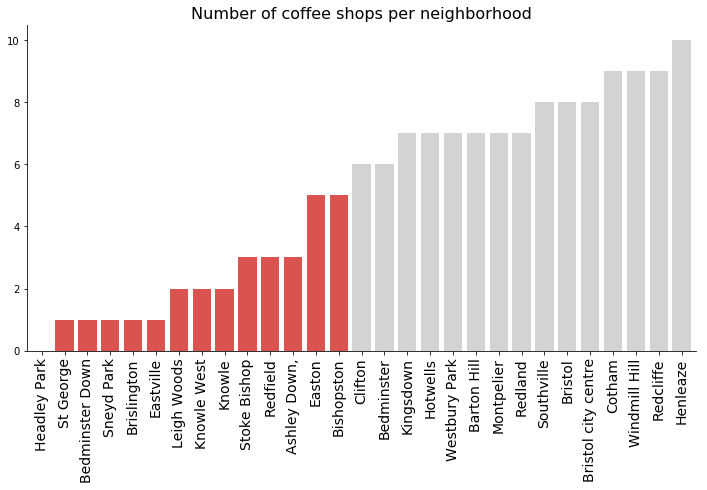

In [35]:
%matplotlib inline 

#coffee_per_neigh.loc[-1] = ['Headley Park', 0]  # adding a row
#coffee_per_neigh.index = coffee_per_neigh.index + 1  # shifting index
#coffee_per_neigh = coffee_per_neigh.sort_index()  # sorting by index

dataDF = coffee_per_neigh.set_index('Neighborhood')
xtick_labels = list(dataDF.index.values)

ax = dataDF.plot(kind='bar', figsize=(12, 6), width=0.8, color=[['#d9534f']*14+['#D3D3D3']*15])
ax.set_title("Number of coffee shops per neighborhood", fontsize=16)
ax.set_xlabel('')
ax.set_xticklabels(xtick_labels, fontdict={'fontsize':14})
#ax.set_yticks([]) # remove yticks
ax.get_legend().remove()

# remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)

#### Create the Bristol bubble map to see coffee shop densities in neighborhoods of Bristol

In [15]:
# create map
map_cofBristol = folium.Map(location=[brist_lat, brist_long], zoom_start=13)
folium.Marker([brist_lat, brist_long], popup='Bristol').add_to(map_cofBristol)
for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    if poi in coffee_per_neigh['Neighborhood'].tolist():
        scale = coffee_per_neigh[coffee_per_neigh['Neighborhood']==str(poi)]['Coffee_Venues'].tolist()[0]
        folium.CircleMarker([lat, lon], radius=3*(scale+1), color='blue', popup=label, 
                            fill=True, fill_color='red', fill_opacity=0.5).add_to(map_cofBristol) 
    else:
        print(poi)
        folium.CircleMarker([lat, lon], radius=5, color='blue', popup=label, 
                            fill=True, fill_color='blue', fill_opacity=0.7).add_to(map_cofBristol) 
map_cofBristol

The map shows a high density of coffee shops around the center of Bristol. Well it is expected that most businesses or coffee shops should be around this center because lots of people will be within these neighborhoods, especially tourists, and workers, including travellers who will pass through the busy city center to catch a bus or a train. We also see that there is high density up North and down south. Generally, the density of coffee shops descreases as we move away from the center of Bristol.

Possible neighborhoods we can consider are Sneyd Park, Leigh Woods, Eastville, Bedminster Down, Knowle West, Knowle, Birislington, St. George, East Ville, Red Field, Stoke Bishop, Ashley Down. These neighborhoods have low density but they are further from the city center. Leigh Wood is mostly woodland and not ideal for business. Bedminster Down, Sneyd Park and Headley Park is mostly residential and therefore not ideal for business. 

Based on this observation and the saturation of coffee shops around the city center, we take the search to neighborhoods which have **less than 5 coffee shops** to meet the requirements by stakeholders. We exclude Leigh Wood and areas which are mostly residential. Note that our initial search radius was 2000 meters, so this number of coffee shops within the radius is sparse for a coffee shop to thrive. We can cluster the neighborhoods selected using **k-means clustering** to know common characteristics of neighborhoods for batch filtering. This will help narrow it down.

**Candidate neighborhoods selected based on the number of coffee shops in the neighborhood as well as the economic status  of the neighborhood**

In [16]:
hoods_select = coffee_per_neigh[(coffee_per_neigh['Coffee_Venues']<=5) & 
                                (coffee_per_neigh['Neighborhood']!='Leigh Woods') & 
                                (coffee_per_neigh['Neighborhood']!='Bedminster Down') &
                                (coffee_per_neigh['Neighborhood']!='Sneyd Park') &
                                (coffee_per_neigh['Neighborhood']!='Headley Park')]['Neighborhood'].reset_index(drop=True)

In [17]:
hoods_select 

0       St George
1     Brislington
2       Eastville
3     Knowle West
4          Knowle
5    Stoke Bishop
6        Redfield
7    Ashley Down,
8          Easton
9      Bishopston
Name: Neighborhood, dtype: object

Get venues in selected neighborhood for clustering

In [18]:
neigh_venues = venues[venues['Neighborhood'].apply(lambda x: x in hoods_select.tolist())].reset_index(drop=True)
neigh_venues['Neighborhood'].value_counts()

Easton          100
Bishopston      100
Ashley Down,     98
Redfield         71
Knowle West      58
Eastville        51
Knowle           51
Brislington      41
St George        38
Stoke Bishop     37
Name: Neighborhood, dtype: int64

**Lets analyze each of these neighborhoods**

In [19]:
# one hot encoding
neigh_venues_onehot = pd.get_dummies(neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neigh_venues_onehot['Neighborhood'] = neigh_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = list(neigh_venues_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
cols = ['Neighborhood'] + cols
neigh_venues_onehot = neigh_venues_onehot[cols]

**Let's group rows by neighborhood and take the mean of the frequency of occurrence of each category**

In [20]:
neigh_venues_grouped = neigh_venues_onehot.groupby('Neighborhood').mean().reset_index()
neigh_venues_grouped

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Baby Store,Bakery,Bar,Beer Garden,Bistro,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Caribbean Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Discount Store,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Hobby Shop,Hotel,Hotel Bar,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Music Venue,Nightclub,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Restaurant,Rock Climbing Spot,Sandwich Place,Scandinavian Restaurant,Shopping Mall,Shopping Plaza,Soccer Field,Sporting Goods Shop,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Warehouse,Warehouse Store,Wine Shop,Zoo Exhibit
0,"Ashley Down,",0.010204,0.010204,0.000000,0.00,0.000000,0.010204,0.000000,0.020408,0.051020,0.010204,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010204,0.000000,0.010204,0.112245,0.010204,0.010204,0.010204,0.000000,0.030612,0.020408,0.00,0.010204,0.00,0.00,0.000000,0.000000,0.000000,0.010204,0.010204,0.010204,0.010204,0.000000,0.010204,0.00,0.000000,0.000000,0.020408,0.000000,0.00000,0.040816,0.000000,0.010204,0.030612,0.010204,0.020408,0.000000,0.000000,0.00,0.051020,0.010204,0.010204,0.00,0.000000,0.010204,0.000000,0.000000,0.010204,0.010204,0.020408,0.010204,0.00,0.000000,0.000000,0.000000,0.000000,0.010204,0.010204,0.010204,0.010204,0.030612,0.000000,0.000000,0.000000,0.000000,0.00,0.163265,0.00,0.010204,0.000000,0.010204,0.010204,0.000000,0.000000,0.000000,0.000000,0.00,0.010204,0.020408,0.00,0.010204,0.020408,0.000000,0.000000,0.000000,0.010204,0.010204,0.000000,0.00,0.000000
1,Bishopston,0.000000,0.010000,0.000000,0.01,0.000000,0.000000,0.000000,0.020000,0.090000,0.010000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.110000,0.010000,0.000000,0.000000,0.000000,0.050000,0.010000,0.00,0.010000,0.02,0.00,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.050000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.00,0.030000,0.010000,0.020000,0.01,0.000000,0.010000,0.000000,0.000000,0.010000,0.010000,0.020000,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.180000,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.010000,0.010000,0.00,0.020000,0.030000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000
2,Brislington,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.097561,0.000000,0.00,0.00,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.048780,0.000000,0.000000,0.000000,0.024390,0.024390,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.024390,0.024390,0.000000,0.000000,0.097561,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.048780,0.000000,0.02439,0.000000,0.000000,0.000000,0.073171,0.000000,0.000000,0.024390,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.024390,0.024390,0.000000,0.000000,0.000000,0.024390,0.00,0.000000,0.000000,0.024390,0.000000,0.024390,0.024390,0.024390,0.000000,0.073171,0.000000,0.000000,0.000000,0.000000,0.00,0.048780,0.00,0.000000,0.000000,0.0487

In [21]:
# We borrow a function to sort values in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Lets display the top 10 venues for each neighborhood**

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neigh_venues_grouped['Neighborhood']

for ind in np.arange(neigh_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neigh_venues_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)

(10, 11)


In [23]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Ashley Down,",Pub,Café,Indian Restaurant,Bar,Gastropub,Pizza Place,Grocery Store,Coffee Shop,Middle Eastern Restaurant,Convenience Store
1,Bishopston,Pub,Café,Bar,Gastropub,Coffee Shop,Burger Joint,Thai Restaurant,Indian Restaurant,Movie Theater,Tapas Restaurant
2,Brislington,Bar,Supermarket,Fast Food Restaurant,Pizza Place,Grocery Store,Sandwich Place,Furniture / Home Store,Café,Pub,Park
3,Easton,Pub,Café,Bar,Park,Coffee Shop,Grocery Store,Burger Joint,Hotel,Department Store,Italian Restaurant
4,Eastville,Pub,Grocery Store,Park,Gym / Fitness Center,Café,Supermarket,Furniture / Home Store,Food,Indian Restaurant,Fast Food Restaurant
5,Knowle,Pub,Fast Food Restaurant,Supermarket,Platform,Bar,Pizza Place,Sandwich Place,Coffee Shop,Furniture / Home Store,Grocery Store
6,Knowle West,Pub,Grocery Store,Pizza Place,Bar,Sandwich Place,Fast Food Restaurant,Furniture / Home Store,Warehouse Store,Pharmacy,Coffee Shop
7,Redfield,Grocery Store,Pub,Café,Supermarket,Fast Food Restaurant,Gym / Fitness Center,Furniture / Home Store,Coffee Shop,Pizza Place,Chinese Restaurant
8,St George,Grocery Store,Pub,Café,Supermarket,Gym / Fitness Center,Climbing Gym,Movie Theater,Donut Shop,Electronics Store,Chinese Restaurant
9,Stoke Bishop,Grocery Store,Pub,Park,Coffee Shop,Restaurant,Café,Supermarket,Garden,Indian Restaurant,Plaza


**Cluster Neighborhoods using k-means clustering for batch filtering**

In [24]:
# set number of clusters
kclusters = 3

neigh_venues_grouped_clustering = neigh_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neigh_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 2, 1, 2, 0, 1, 1, 0, 0, 0], dtype=int32)

Lets create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df
# merge df_grouped with df to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
# remove redundant rows, should hvae been processed earlier
df_merged.dropna(subset=['Cluster Labels'], inplace=True)
# fix datatype
df_merged[['Cluster Labels']] = df_merged[['Cluster Labels']].astype('int64')
# drop unnecessary columns
df_merged = df_merged.drop(['PostCode', 'PostTown', 'Address'], axis=1)
#reset index
df_merged.reset_index(drop=True)
print(df_merged.shape)
df_merged 

(10, 15)


,Neighborhood,Longitude,Latitude,Distance_from_Center,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Brislington,-2.552578,51.433103,3.869224,1,Bar,Supermarket,Fast Food Restaurant,Pizza Place,Grocery Store,Sandwich Place,Furniture / Home Store,Café,Pub,Park
7,Knowle,-2.566746,51.433783,3.077803,1,Pub,Fast Food Restaurant,Supermarket,Platform,Bar,Pizza Place,Sandwich Place,Coffee Shop,Furniture / Home Store,Grocery Store
8,Knowle West,-2.586367,51.426664,3.113485,1,Pub,Grocery Store,Pizza Place,Bar,Sandwich Place,Fast Food Restaurant,Furniture / Home Store,Warehouse Store,Pharmacy,Coffee Shop
9,Easton,-2.567684,51.464703,2.389000,2,Pub,Café,Bar,Park,Coffee Shop,Grocery Store,Burger Joint,Hotel,Department Store,Italian Restaurant
10,St George,-2.545106,51.459566,3.683950,0,Grocery Store,Pub,Café,Supermarket,Gym / Fitness Center,Climbing Gym,Movie Theater,Donut Shop,Electronics Store,Chinese Restaurant
11,Redfield,-2.552722,51.458781,3.147500,0,Grocery Store,Pub,Café,Supermarket,Fast Food Restaurant,Gym / Fitness Center,Furniture / Home Store,Coffee Shop,Pizza Place,Chinese Restaurant
12,Eastville,-2.559857,51.473305,3.388022,0,Pub,Grocery Store,Park,Gym / Fitness Center,Café,Supermarket,Furniture / Home Store,Food,Indian Restaurant,Fast Food Restaurant
18,Bishopston,-2.595453,51.478305,2.729084,2,Pub,Café,Bar,Gastropub,Coffee Shop,Burger Joint,Thai Restaurant,Indian Restaurant,Movie Theater,Tapas Restaurant
19,"Ashley Down,",-2.585152,51.478287,2.851919,2,Pub,Café,Indian Restaurant,Bar,Gastropub,Pizza Place,Grocery Store,Coffee Shop,Middle Eastern Restaurant,Convenience Store
24,Stoke Bishop,-2.635691,51.480413,3.985340,0,Grocery Store,Pub,Park,Coffee Shop,Restaurant,Café,Supermarket,Garden,Indian Restaurant,Plaza


Lets visualize a map of the clustering

In [26]:
# create map
map_clusters = folium.Map(location=[brist_lat, brist_long], zoom_start=10)
folium.Marker([brist_lat, brist_long], popup='Bristol').add_to(map_clusters)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['darkred', 'purple', 'darkgreen']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

**Examine the clusters by the most common venues**

We note that Cafe is comparable with Coffee Shops. Reason being that cafes normally serve coffee along with other meals. Cafes can be a direct competitor with coffee shops because they might offer more options. If they serve good coffee, one is likely to go there than to go to a coffee shop. Based on this reason we assume cafes as direct competitors and avoid being in the same neighborhood with them if possible.

We examine the 1st most common venue across the cluster of neighborhoods

In [27]:
num_clusters = 3
for  c in range(num_clusters):
    cluster_group = df_merged.loc[df_merged['Cluster Labels'] == c, df_merged.columns[[3] + list(range(4, df_merged.shape[1]))]]
    print('Cluster: ',str(c))
    num_coffee_shops = cluster_group[cluster_group['1st Most Common Venue']=='Coffee Shop']['1st Most Common Venue'].value_counts()
    num_cafe_shops   = cluster_group[cluster_group['1st Most Common Venue'].str.contains('Caf')]['1st Most Common Venue'].value_counts()
    print('Number of coffee shops', num_coffee_shops.tolist())
    print('Number of cafe shops', num_cafe_shops.tolist())
    print('*****'*5)

Cluster:  0
Number of coffee shops []
Number of cafe shops []
*************************
Cluster:  1
Number of coffee shops []
Number of cafe shops []
*************************
Cluster:  2
Number of coffee shops []
Number of cafe shops []
*************************


We find that there is no sign of coffee shops or cafes across the clusters for the 1st most common venues

2nd most common venues across clusters

In [28]:
num_clusters = 3
for  c in range(num_clusters):
    cluster_group = df_merged.loc[df_merged['Cluster Labels'] == c, df_merged.columns[[3] + list(range(4, df_merged.shape[1]))]]
    print('Cluster: ',str(c))
    num_coffee_shops = cluster_group[cluster_group['2nd Most Common Venue']=='Coffee Shop']['2nd Most Common Venue'].value_counts()
    num_cafe_shops   = cluster_group[cluster_group['2nd Most Common Venue'].str.contains('Caf')]['2nd Most Common Venue'].value_counts()
    print('Number of coffee shops', num_coffee_shops.tolist())
    print('Number of cafe shops', num_cafe_shops.tolist())
    print('*****'*5)

Cluster:  0
Number of coffee shops []
Number of cafe shops []
*************************
Cluster:  1
Number of coffee shops []
Number of cafe shops []
*************************
Cluster:  2
Number of coffee shops []
Number of cafe shops [3]
*************************


We find that for the 2nd most common venue across the clusters, **Cluster 2 has an occurence of Cafe** for each of the neighborhood in the cluster.  To this end, we exclude all neighborhoods in Cluster 2.

St. George, Redfield also have Cafes as the 3rd most common venue, with Eastville having a Cafe in the 4th most common. Eventhough Eastville and St. Geaorge has just 1 occurence of a coffee shop in each of the neighborhoods. They all belong to Cluster 0. Comparing this to Cluster 1, we observe that the coffee shop/cafe do not occur till the 8th most common venue in the neigborhoods  in Cluster 1. Based on this reason we exclude neighborhoods in Cluster 0.

**Examine Cluster 1**

The promising cluster of neighborhoods is cluster 1  
Lets examine

In [29]:
cluster_1 = df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[0] + list(range(1, df_merged.shape[1]))]]
cluster_1

,Neighborhood,Longitude,Latitude,Distance_from_Center,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Brislington,-2.552578,51.433103,3.869224,1,Bar,Supermarket,Fast Food Restaurant,Pizza Place,Grocery Store,Sandwich Place,Furniture / Home Store,Café,Pub,Park
7,Knowle,-2.566746,51.433783,3.077803,1,Pub,Fast Food Restaurant,Supermarket,Platform,Bar,Pizza Place,Sandwich Place,Coffee Shop,Furniture / Home Store,Grocery Store
8,Knowle West,-2.586367,51.426664,3.113485,1,Pub,Grocery Store,Pizza Place,Bar,Sandwich Place,Fast Food Restaurant,Furniture / Home Store,Warehouse Store,Pharmacy,Coffee Shop


Brislington, Knowle and Knowle West are competitive neighborhoods to establish a coffee shop. Reason being that Brislington has no coffee shop but a cafe which is synanymous to a coffee shop. However, Brislington is further away from the city center than Knowle and Knowle West. Knowle West on the other hand is known to be a deprive area, whereby 6 areas out of 8 areas in Knowle West is ranked deprived as noted in _*Filwood Ward Profile 2008, p. 9*_. As such the best neighborhood to establish a coffee shop is **Knowle**.

Knowle is about **3km away from the city center** and has only 2 coffee shop within a radius of 2000m, and the 8th most common venue from the center of Knowle. More importantly the neighborhood of Knowles is just next to the A37 motorway, creating an excellent opportunity for travellers to stop by and grab a cup of coffee for the road. **Knowle has longitude -2.566746 and latitude 51.433783**.

**Map of suggested neighborhood relative to Bristol city center**

In [30]:
finalmap_city = folium.Map(location=[brist_lat, brist_long], zoom_start=13)
folium.Marker([brist_lat, brist_long], popup='Bristol').add_to(finalmap_city)
lat =  51.433783
lon = -2.566746
label = 'Knowle, Bristol'
folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.5).add_to(finalmap_city)
finalmap_city

##### We conclude the analysis. We have suggested the best neighborhood among the neighborhoods in Bristol to establish a coffee shop.   
All neighborhoods analysed were within a 4km of the city center of Bristol. We observed that most of the neighborhoods around the city center are already saturated with coffee shops. So we moved our search to the outskirt of the radius. In those areas, either is residential or woodland. Further analysis on the data including external sources hinted us that the best neighborhood is Knowles. 

## 5. Results and Discussion <a name="results"></a>

The analysis shows that although Bristol has a lot of coffee shops (a minimum of 6 restaurants up to 10 restaurants within a ~2000 meters radius of each neighborhood), we find that a couple of neighborhoods not very far from the city center are less densed with coffee shops or cafes. The highest concentration of coffee shops spread from the north down to the south, while we observed that the density of coffee shops reduced as we move further away from the city center. We found out that some neighborhoods with less coffee shop density were either residential areas or forest areas. Excluding those areas in our search, we centered our attention to those which had less than 5 coffee shops within a 4km radius from city center, as that was the basic requirement as discussed with stakeholders. That left us with Easton, Bishopston, Ashley Down, Redfield, Knowle West, Eastville, Knowle, Brislington, St. George and Stoke Bishop.

Directing our attention to these neighborhoods, we perform a k-means clustering to group the neighborhoods based on venues within the neighborhood. This helped us tell the importance of coffee shops in the neighborhood by looking at the most common venue. Noting that cafes are direct competitors with coffee shops, we also examine where cafes are ranked as the most common venues. We wish to avoid neighborhoods with cafes as well to avoid comptetion. This narrowed our search to the cluster which contains the neighborhoods Knowle, Knowle West and Brislington.

Using other external information for Knowle, Knowle West and Brislington, we optimally chose the right neighborhood. Specifically, a quick search on Knowle West indicated that the neighborhood is deprived and not econmically stable. Hence a coffee shop business will not survive in such a neighborhood. Also eventhough Brislington have no coffee shops when observing up to the 10th most common venue, they have cafe ranked as the 8th most common venue, which is comparable to a coffee shop. Knowle has coffee shops as well as the 8th most common venue. However, Knowle is closer to Brislington and it stretches along the motorway, which will be ideal for travelers to make a stopover to grab a coffee. Eventhough we suggest Knowle as the optimal neighborhood to start a business, it does not imply other neighborhoods cannot do better. The result is based on the parameters used and the requirement of the stakeholders.

## 6. Conclusion<a name="conclusion"></a>

The aim of this project was to identify the optimal neighborhood close to the city center which has very few coffee shops, with the goal to advise stakeholders on the best neighborhood to establish a coffee shop. We perform extensive analysis using venue data provided by Foursquare as well as neighborhood data scraped from Wikipedia. By calculating certain statics such as the density distribution of coffee shops in neighborhoods, as well as the distance from neighborhoods to the city center we could narrow our search. Further analysis such as clustering using k-means on filtered neighborhoods gave us insight on the importance of coffee shops within each neighborhood. We realised that cafes also will play a role and included this as a factor when choosing the optimal neighborhood. 

It came down to the battle of 3 neighborhoods, namely Knowles, Brislington and West Knowles. But as discussed, taking into account additional factor like the economic status of the neighborhood and the distance to city, we can strongly advise that Knowles is the best neighborhood to establish a coffee house. However, additional factors not considered in this project could shift the optimal neighborhood among these 3 neighborhoods. Factor that might be interesting will include proximity to a car park and other social amenities interesting to customers of the coffee shop.